In [1]:
"""
Poisson leap process
""";

In [2]:
using Distributed, Plots, DelimitedFiles, KernelDensity

In [3]:
length(Sys.cpu_info())
addprocs(4) ;

In [4]:
@everywhere using Random, Distributions

In [5]:
@everywhere struct SPN
    init_pops::Vector{Real}
    rate_vec::Vector{Real}
    Stoichiometry_matrix::Array{Real, 2}
    function SPN(init_pops, rate_vec, Stoichiometry_matrix)
        new(init_pops, rate_vec, Stoichiometry_matrix)
    end
end

In [6]:
@everywhere init(N::SPN) = Float64.(N.init_pops)
@everywhere rates(N::SPN) = Float64.(N.rate_vec)
@everywhere StoiMat(N::SPN) = Float64.(N.Stoichiometry_matrix)

In [7]:
post = [[2,0,0,0,1] [0,2,0,0,1]]
pre = [[1,0,1,0,1] [0,1,0,1,0]]
S = post - pre
k = [3.06e-8, 3.06e-8, 3.06e-8, 3.06e-8, 0.0, 2e-3, 2e-3];

In [350]:
hour = 3600
day = 24*hour
year = 365*day

step_str = "1"
step = 1*day
step_out = 7*day

Tmax = 80*year 
Nsim = 1000 ;

In [351]:
@everywhere function hazard(x::Vector{Float64},th::Vector{Float64},c0::Float64)::Vector{Float64}
    error = sum(x) - c0
    W = x[1]
    M = x[2]
    k = th[1:5]
    Kc = th[6:7]
    if error > 0
        k1 = 2*k[1]/(1+exp(error*Kc[1]))
        k2 = 2*k[2]/(1+exp(error*Kc[1]))
        return [W,M,W,M,W] .* [k1, k2, th[3], th[4], th[5]]
    else 
        k1 = k[1]*(1+exp(-error*Kc[2]))/2
        k2 = k[2]*(1+exp(-error*Kc[2]))/2
        return [W,M,W,M,W] .* [k1, k2, th[3], th[4], th[5]]
    end
end

In [352]:
@everywhere function randPois(λ::Vector{Float64})::Vector{Int64}
    pos_rates = (λ.>0).*λ
    [rand(Poisson(rate)) for rate in pos_rates]
end

In [353]:
@everywhere function transform_summ(popdym)::Array{Float64}
    copy_num = popdym[:,1] .+ popdym[:,2]
    
    nonzero_idx = copy_num .!= 0.0
    mut_load = fill(NaN, length(copy_num))
    mut_load[nonzero_idx] .= popdym[nonzero_idx, 2] ./ copy_num[nonzero_idx]
    
    return hcat(copy_num, mut_load)
end

In [354]:
@everywhere function tauleap(spn::SPN, Tmax::Real, dt::Real, dtout::Real)::Array{Float64, 2}
    x = init(spn)
    c0 = sum(x)
    
    k = rates(spn)
    S = StoiMat(spn)
    N = trunc(Int, Tmax/dt) + 1
    Nout = trunc(Int, Tmax/dtout) + 1
    # popdym = Array{Float64}(undef, 2,Nout)
    popdym = fill(-50.0, 2,Nout)
    target = dt
    tt = 0.0
    
    popdym[:,1] = x
    i = 2
    for _=1:N
        while tt<target && i<=Nout
            popdym[:,i] = x
            tt += dtout
            i += 1
        end
        
        h = hazard(x, k, c0)
        R = randPois(h*dt)
        x = x + (S'*R) 
        x[x.<0.0] .= 0.0 
        if( sum(x) == 0.0 )
            popdym[:,(i:Nout)] = zeros(2, Nout-i+1)
            return transform_summ(popdym')
        end
        target += dt
    end
    return transform_summ(popdym')
end


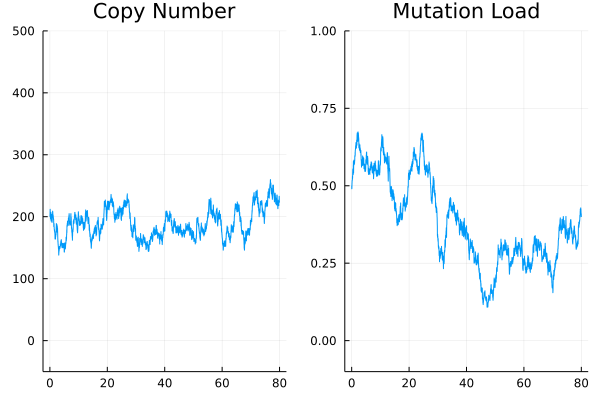

In [355]:
k = [3.06e-8, 3.06e-8, 3.06e-8, 3.06e-8, 0.0, 2e-3, 2e-3]
spn = SPN([100,100], k, S)
tt = tauleap(spn, Tmax, step, step_out)
xt = [0:step_out:Tmax;]./year
plt1 = plot(xt, tt[:,1], ylims=(-50,500), legend=false, title="Copy Number")
plt2 = plot(xt, tt[:,2], ylims=(-0.1,1), legend=false, title="Mutation Load")

plot(plt1, plt2)

In [356]:
"""
sim_single = Array{Float64}(undef, n(Ntest), 2,Nsim)
@time for i=1:Nsim
    sim_single[:,:,i] = tauleap(Ntest)
end
1000 simulations takes ~21 seconds
""";

In [357]:
# The arguments are: 1) a function 'f' and 2) a list with the input.
@everywhere function par_map(Nsim::Int64, f, spn::SPN, Tmax::Real, dt::Real, dtout::Real)
    np = nworkers()            # Number of processes available.
    output = Vector{Array{Float64, 2}}(undef, Nsim) 
    i = 1
    nextidx() = (idx = i; i += 1; idx) # Function to know which is the next work item.
    @sync begin #@sync: must complete all jobs in block
        for p = 1:np # loops through all processes (workers)
            if p != myid() || np == 1 # first worker used only if all others are busy 
                @async begin # launch several tasks simultaneaously
                    while true
                        idx = nextidx()
                        if idx > Nsim
                            break
                        end
                        output[idx] = remotecall_fetch(f, p, spn, Tmax, dt, dtout)
                    end
                end
            end
        end
    end
    output
end

In [358]:
@time simulations = par_map(Nsim, tauleap, spn, Tmax, step, step_out) ;

  8.014950 seconds (149.56 k allocations: 69.680 MiB, 0.43% compilation time)


In [359]:
"""
time step = 200 days
time taken: ~ 0.14 seconds
4 workers, 1000 simulations

time step = 150 days
time taken: 0.15 seconds
4 workers, 1000 simulations

time step = 100 days
simple simulation: ~ 0.18 seconds
workers = 4

time step = 50 days 
simple simulation: ~0.32 seconds
workers = 4

time step = 25 days
simple sim: ~0.55 seconds
workers = 4

time step = 10 days
simple sim = ~1.2 seconds

time step = 7 days
simple simulation: ~2.5 seconds
workers = 4, 1000 simulations

time steo = 5 days
simple simulation: 2.7 seconds
4 workers, 1000 simulations 

time step = 2 days
simple simulations: ~ 6.5 seconds
4 workers, 1000 simulations

time step = 1 day
simple simulation: 8.5 seconds
workers = 4, 1000 simulations

""";

In [360]:
@everywhere function quantiles(sims, p)::Array{Float64, 3}
    """
    returns quantile summaries from simulations
    """
    Nsim = length(sims) # Nsim: number of simulations
    n = size(sims[1])[1] # length of one simulation
    out = Array{Float64}(undef, n,length(p),2)
    for t=1:n
        out[t,:,1] = quantile([sims[i][t,1] for i=1:Nsim if !isnan(sims[i][t,1])], p)
        out[t,:,2] = quantile([sims[i][t,2] for i=1:Nsim if !isnan(sims[i][t,2])], p)
    end
    out
end

In [361]:
sims_qntl = quantiles(simulations, [0.025,0.25,0.5,0.75,0.975]) ;

In [362]:
mkpath("Simulations")
writedlm(string("Simulations/CN_qnt_taucon_",step_str,"d.txt"), sims_qntl[:,:,1])
writedlm(string("Simulations/ML_qnt_taucon_",step_str,"d.txt"), sims_qntl[:,:,2]) ;

In [363]:
mkpath("Simulations/PDF")
myBlack = colorant"rgb(0,0,0,0.1)"
ts = [0:step_out:Tmax;]./year ;

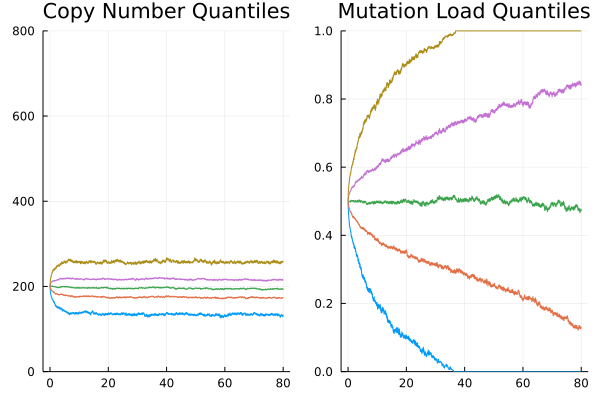

In [364]:
p3 = plot(ts, sims_qntl[:,:,1], title="Copy Number Quantiles", ylims=(0,800))
p4 = plot(ts, sims_qntl[:,:,2], title="Mutation Load Quantiles", ylims=(0,1))
plot(p3, p4, layout=(1,2), legend=false)
#savefig(string("Simulations/PDF/taucon_qntls_",step_str,"d.pdf"))

In [365]:
function time_slice(sims, t, Tmax, dtout)
    t_low = [0:dtout:Tmax-dtout;]
    t_up = [dtout:dtout:Tmax;]
    Nsim = length(sims)
    nt = length(t)
    sim_slice = Array{Any, 3}(undef, Nsim,nt,2)
    for i=1:Nsim
        for j=1:nt
            indx = t[j].>=t_low .& t[j].<t_up
            sim_slice[i,j,1] = sims[i][vcat(indx, false),1]
            sim_slice[i,j,2] = sims[i][vcat(indx, false),2]
        end
    end
    return sim_slice
end

time_slice (generic function with 1 method)

In [366]:
dist_sims = time_slice(simulations, [10:10:80;]*year, Tmax, step_out) ; 

In [367]:
"""
Simulation times
""" ;

In [368]:
@everywhere function par_times(Nsim, f, spn::SPN, Tmax::Real, dt::Real, dtout::Real)
    np = nworkers()            # Number of processes available.
    Nout = trunc(Int, Tmax/dtout) + 1 # dimension for output
    output = Array{Float64}(undef, Nsim) # Where we will write the results. As we do not know
                             # the type (Integer, Tuple...) we write "Any"
    i = 1
    nextidx() = (idx = i; i += 1; idx) # Function to know which is the next work item.
                                       # In this case it is just an index.
    @sync begin #@sync: must complete all jobs in block
        for p = 1:np # loops through all processes (workers)
            if p != myid() || np == 1 # first worker used only if all others are busy 
                @async begin # launch several tasks simultaneaously
                    while true
                        idx = nextidx()
                        if idx > Nsim
                            break
                        end
                        output[idx] = @elapsed remotecall_fetch(f, p, spn, Tmax, dt, dtout)
                    end
                end
            end
        end
    end
    output
end

In [369]:
sim_times = par_times(Nsim, tauleap, spn, Tmax, step, step_out) 

mkpath("Simulations")
writedlm(string("Simulations/taucon_",step_str,"d_times.txt"), sim_times) ;

In [370]:
dens = kde(sim_times)
density_points = hcat(dens.x, dens.density) ;

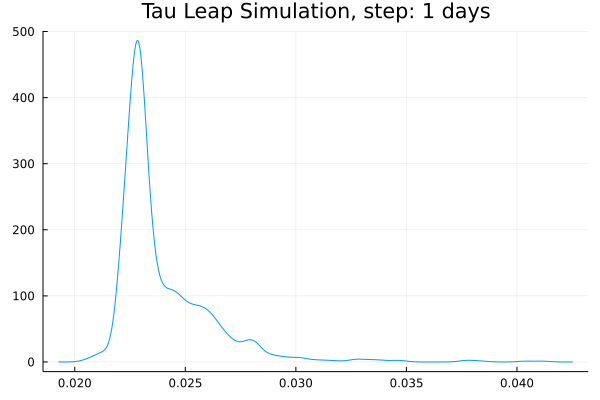

In [371]:
plot(dens.x, dens.density, legend=false, title=string("Tau Leap Simulation, step: ",step_str," days"))